<a href="https://colab.research.google.com/github/hongyuw0427/Final-Year-Project/blob/main/FYP_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Fixed & memory-friendly hyperparameter tuning script
# - Uses sparse TF-IDF (no .toarray())
# - Uses LinearSVC + CalibratedClassifierCV for speed & probabilities
# - Combines sparse TF-IDF + dense embeddings via scipy.sparse.hstack
# - Smaller search spaces, cv=2, n_jobs=1 to limit memory
# - BiLSTM tuning uses small search and smaller model sizes

import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# faster SVM for sparse data
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

from scipy.sparse import hstack, csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Install keras-tuner if not present (run once)
# In Colab you can run this cell first; keep it commented if already installed
# !pip install -q -U keras-tuner

import keras_tuner as kt

# ----------------------------
# Config
# ----------------------------
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/FYP/cyberbullying_tweets_cleaned.csv"
OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/FYP/hyperparameter_tuning"
os.makedirs(OUTPUT_DIR, exist_ok=True)

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ----------------------------
# Load data
# ----------------------------
df = pd.read_csv(DATA_PATH)
texts = df["clean_text"].astype(str).tolist()
labels = df["cyberbullying_type"].astype(str).tolist()

le = LabelEncoder()
y = le.fit_transform(labels)
num_classes = len(le.classes_)
print("Classes:", le.classes_)

# fixed split for tuning (80/20)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=SEED, stratify=y
)

# ----------------------------
# Confusion matrix helper
# ----------------------------
def show_and_save_confusion_matrix(y_true, y_pred, labels, filename):
    cm = confusion_matrix(y_true, y_pred)
    print("\n" + "="*40)
    print(f"Confusion Matrix: {filename}")
    print("="*40)
    print(cm)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(filename)
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(save_path)
    plt.show()
    print("Saved:", save_path)

# ----------------------------
# Feature extraction for classical models (fusion)
# Keep TF-IDF sparse (no .toarray())
# ----------------------------
print("Computing TF-IDF (sparse)...")
tfidf = TfidfVectorizer(max_features=3000,  # reduce features to save memory
                        ngram_range=(1,2),
                        stop_words='english')
tfidf.fit(texts)
X_train_tfidf = tfidf.transform(X_train_text)   # sparse
X_test_tfidf  = tfidf.transform(X_test_text)    # sparse

print("Computing sentence embeddings (dense)...")
embedder = SentenceTransformer("all-MiniLM-L6-v2")
# encode in batches is handled by sentence-transformers
X_train_emb = embedder.encode(X_train_text, convert_to_numpy=True, show_progress_bar=True)
X_test_emb  = embedder.encode(X_test_text, convert_to_numpy=True, show_progress_bar=True)

# convert dense embeddings to sparse CSR to hstack with tfidf, but we can hstack with dense as well using scipy
X_train_emb_sp = csr_matrix(X_train_emb)
X_test_emb_sp  = csr_matrix(X_test_emb)

print("Combining TF-IDF (sparse) + Embeddings (sparse) via hstack...")
X_train = hstack([X_train_tfidf, X_train_emb_sp], format='csr')
X_test  = hstack([X_test_tfidf,  X_test_emb_sp],  format='csr')

print("Fusion shapes:", X_train.shape, X_test.shape)




Classes: ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'other_cyberbullying'
 'religion']
Computing TF-IDF (sparse)...
Computing sentence embeddings (dense)...


Batches:   0%|          | 0/1144 [00:00<?, ?it/s]

Batches:   0%|          | 0/286 [00:00<?, ?it/s]

Combining TF-IDF (sparse) + Embeddings (sparse) via hstack...
Fusion shapes: (36588, 3384) (9148, 3384)



TUNING SVM (LinearSVC wrapped with CalibratedClassifierCV)...
Training LinearSVC (C=0.1) + calibration...
 C=0.1 -> f1_macro=0.8224
Training LinearSVC (C=1) + calibration...
 C=1 -> f1_macro=0.8225
Training LinearSVC (C=3) + calibration...
 C=3 -> f1_macro=0.8186
Best SVM params: {'C': 1} best f1: 0.8224853176614128

Confusion Matrix: CM_SVM_TUNED.png
[[1553    4    2   14   14    4]
 [   1 1541    2   10    9    6]
 [   2    4 1256  123  113   10]
 [  35   10   60  793  512   62]
 [  17   11   76  412  938    3]
 [   1    3    7   37   15 1488]]


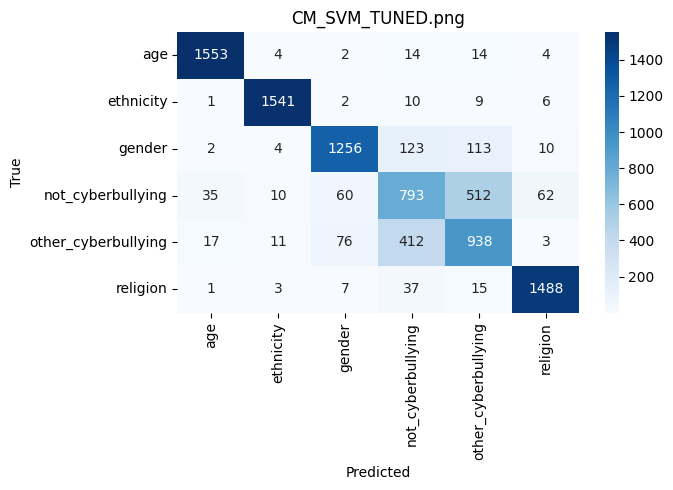

Saved: /content/drive/MyDrive/Colab Notebooks/FYP/hyperparameter_tuning/CM_SVM_TUNED.png


In [6]:
# ----------------------------
# TUNE SVM (use LinearSVC + CalibratedClassifierCV)
# - smaller grid, cv=2, n_jobs=1 to avoid memory spikes
# ----------------------------
print("\nTUNING SVM (LinearSVC wrapped with CalibratedClassifierCV)...")

svc = LinearSVC(random_state=SEED, max_iter=10000)
calib = CalibratedClassifierCV(svc, cv=2)   # cv=2 inside calibration

param_grid_svc = {
    "base_estimator__C": [0.1, 1, 3]  # small grid
}

# Note: to use GridSearchCV with CalibratedClassifierCV we need to pass the calibrated wrapper as estimator and param names accordingly
# But GridSearchCV cannot directly access base_estimator__C in this wrapper in all scikit versions.
# Safer approach: grid over C manually: train several CalibratedClassifierCV with different C
best_svm = None
best_score = -1
best_params = None

for C in [0.1, 1, 3]:
    print(f"Training LinearSVC (C={C}) + calibration...")
    svc = LinearSVC(C=C, random_state=SEED, max_iter=10000)
    calib = CalibratedClassifierCV(svc, cv=2)
    calib.fit(X_train, y_train)   # supports sparse input
    preds = calib.predict(X_test)
    f1 = f1_score(y_test, preds, average='macro')
    print(f" C={C} -> f1_macro={f1:.4f}")
    if f1 > best_score:
        best_score = f1
        best_svm = calib
        best_params = {"C": C}

print("Best SVM params:", best_params, "best f1:", best_score)

svm_pred = best_svm.predict(X_test)
svm_proba = best_svm.predict_proba(X_test)

show_and_save_confusion_matrix(y_test, svm_pred, le.classes_, "CM_SVM_TUNED.png")

svm_results = {
    "model": "SVM_TUNED",
    "accuracy": accuracy_score(y_test, svm_pred),
    "precision": precision_score(y_test, svm_pred, average="macro"),
    "recall": recall_score(y_test, svm_pred, average="macro"),
    "f1": f1_score(y_test, svm_pred, average="macro"),
    "roc_auc": roc_auc_score(label_binarize(y_test, classes=range(num_classes)),
                             svm_proba, average="macro", multi_class="ovr")
}




TUNING Logistic Regression (fusion)...
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best LR params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'} best f1: 0.8195509202978036

Confusion Matrix: CM_LR_TUNED.png
[[1549    3    4   18   14    3]
 [   1 1530    5   10   16    7]
 [   4    7 1249  131  107   10]
 [  27   12   62  809  504   58]
 [  19   10   71  416  937    4]
 [   1    5    7   42   12 1484]]


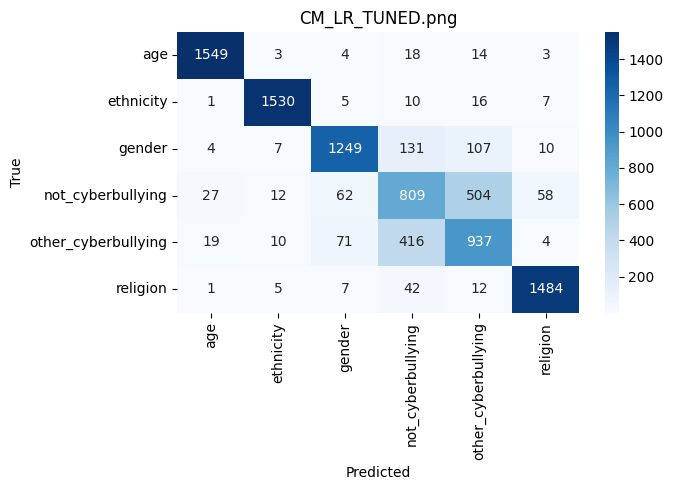

Saved: /content/drive/MyDrive/Colab Notebooks/FYP/hyperparameter_tuning/CM_LR_TUNED.png


In [7]:
# ----------------------------
# TUNE Logistic Regression (fusion)
# - small grid; solver lbfgs supports l2 only; saga is fine but slower
# - use n_jobs=1 to reduce parallel memory spikes
# ----------------------------
print("\nTUNING Logistic Regression (fusion)...")
param_grid_lr = {
    "C": [0.1, 1, 3],
    "solver": ["lbfgs"],   # keep simple and stable
    "penalty": ["l2"]
}

lr = LogisticRegression(max_iter=2000, multi_class='multinomial')
grid_lr = GridSearchCV(lr, param_grid_lr, scoring="f1_macro", cv=2, verbose=1, n_jobs=1)
grid_lr.fit(X_train, y_train)   # accepts sparse matrices

best_lr = grid_lr.best_estimator_
print("Best LR params:", grid_lr.best_params_, "best f1:", grid_lr.best_score_)

lr_pred = best_lr.predict(X_test)
lr_proba = best_lr.predict_proba(X_test)

show_and_save_confusion_matrix(y_test, lr_pred, le.classes_, "CM_LR_TUNED.png")

lr_results = {
    "model": "LR_TUNED",
    "accuracy": accuracy_score(y_test, lr_pred),
    "precision": precision_score(y_test, lr_pred, average="macro"),
    "recall": recall_score(y_test, lr_pred, average="macro"),
    "f1": f1_score(y_test, lr_pred, average="macro"),
    "roc_auc": roc_auc_score(label_binarize(y_test, classes=range(num_classes)),
                             lr_proba, average="macro", multi_class="ovr")
}



Trial 4 Complete [00h 04m 09s]
val_accuracy: 0.8106039762496948

Best val_accuracy So Far: 0.8106039762496948
Total elapsed time: 00h 16m 30s
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step

Confusion Matrix: CM_BiLSTM_TUNED.png
[[1567    1    3    2   15    3]
 [   8 1528    9    3   18    3]
 [  12    1 1285   53  154    3]
 [  53   15   99  514  753   38]
 [  38   12  114  160 1130    3]
 [  17   12   17   57   14 1434]]


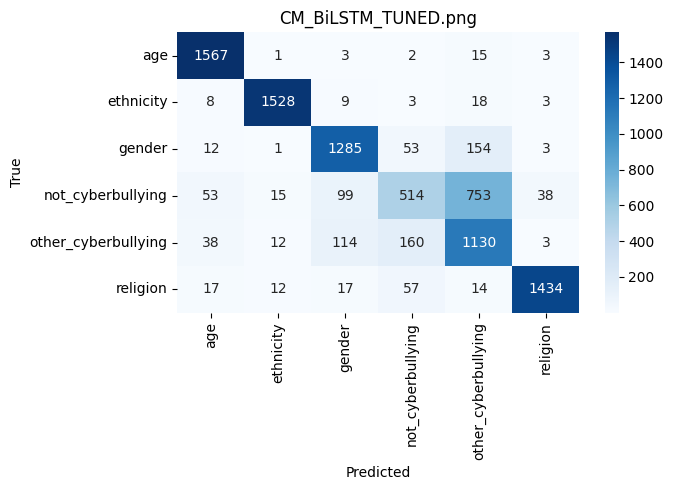

Saved: /content/drive/MyDrive/Colab Notebooks/FYP/hyperparameter_tuning/CM_BiLSTM_TUNED.png


In [8]:
# ----------------------------
# TUNE BiLSTM (deep learning) — separate representation (TOKENIZED sequences)
# - use smaller vocab and shorter search to avoid RAM crash
# ----------------------------
print("\nTUNING BiLSTM (tokenized sequences)...")

MAX_WORDS = 20000
MAX_LEN = 100

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)


def build_bilstm(hp):
    model = keras.Sequential()
    model.add(layers.Embedding(
        input_dim=MAX_WORDS,
        output_dim=hp.Int("embed_dim", 32, 64, step=32)
    ))

    model.add(layers.Bidirectional(layers.LSTM(
        hp.Int("lstm_units", 32, 64, step=16)
    )))

    model.add(layers.Dense(
        hp.Int("dense_units", 32, 64, step=16),
        activation="relu"
    ))

    model.add(layers.Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuner = kt.RandomSearch(
    build_bilstm,
    objective="val_accuracy",
    max_trials=4,
    executions_per_trial=1,
    directory=OUTPUT_DIR,
    project_name="bilstm_tuning_small"
)

tuner.search(X_train_pad, y_train, epochs=3, validation_split=0.1, verbose=2)

best_bilstm = tuner.get_best_models(num_models=1)[0]
bilstm_pred_proba = best_bilstm.predict(X_test_pad, batch_size=128)
bilstm_pred = np.argmax(bilstm_pred_proba, axis=1)

show_and_save_confusion_matrix(y_test, bilstm_pred, le.classes_, "CM_BiLSTM_TUNED.png")

bilstm_results = {
    "model": "BiLSTM_TUNED",
    "accuracy": accuracy_score(y_test, bilstm_pred),
    "precision": precision_score(y_test, bilstm_pred, average="macro"),
    "recall": recall_score(y_test, bilstm_pred, average="macro"),
    "f1": f1_score(y_test, bilstm_pred, average="macro"),
    "roc_auc": roc_auc_score(label_binarize(y_test, classes=range(num_classes)),
                             bilstm_pred_proba, average="macro", multi_class="ovr")
}



In [9]:
# ----------------------------
# Save results
# ----------------------------
results_df = pd.DataFrame([svm_results, lr_results, bilstm_results])
out_path = os.path.join(OUTPUT_DIR, "tuning_results.csv")
results_df.to_csv(out_path, index=False)
print("\nTUNING COMPLETE — results saved to:", out_path)
print(results_df)


TUNING COMPLETE — results saved to: /content/drive/MyDrive/Colab Notebooks/FYP/hyperparameter_tuning/tuning_results.csv
          model  accuracy  precision    recall        f1   roc_auc
0     SVM_TUNED  0.827394   0.823806  0.822176  0.822485  0.965947
1      LR_TUNED  0.826192   0.823599  0.821082  0.821910  0.968482
2  BiLSTM_TUNED  0.815260   0.816644  0.810037  0.802046  0.965400
